# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/




The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 


![Amazon](https://cdn.geekwire.com/wp-content/uploads/2017/08/wholefoods_070519-630x473.jpg)


Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [115]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [116]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# Loading the whole dataset

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [117]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [118]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [119]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [120]:
display['COUNT(*)'].sum()

393063

1    443777
0     82037
Name: Score, dtype: int64


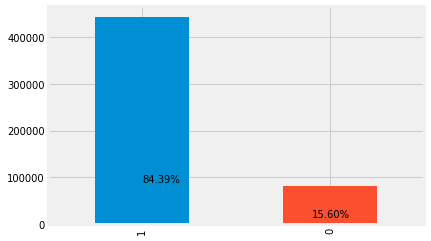

In [121]:
print(filtered_data['Score'].value_counts())
filtered_data['Score'].value_counts().plot.bar()
plt.text(1*(10**-6),90000,"84.39%")
plt.text(0.9, 15000 , "15.60%")
plt.show()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [122]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [123]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [124]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [125]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [126]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [127]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [128]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

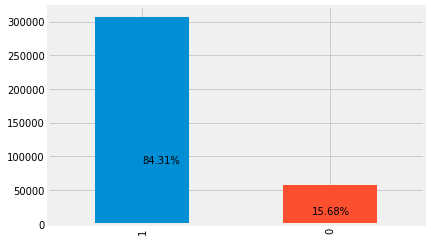

In [129]:
final['Score'].value_counts().plot.bar()
plt.text(1*(10**-6),90000,"84.31%")
plt.text(0.9, 15000 , "15.68%")
plt.show()

In [130]:
del display

In [131]:
#Selecting 50000 data points for actual training as the Feature Engineered Matrices(BOW,TFIDF..)
#have very large dimensions
half_pts = 25000
data_pos = final[final['Score'] == 1][:half_pts]
data_neg = final[final['Score'] == 0][:half_pts]
data = pd.concat([data_pos,data_neg] , axis=0)
print(data.shape)
data.head()

(50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [132]:
data['Score'].value_counts()

1    25000
0    25000
Name: Score, dtype: int64

In [133]:
del data_neg
del data_pos
del final

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [134]:
# printing some random reviews
sent_0 = data['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = data['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = data['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = data['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
Ok cats, you can stop wiggling and showing me your lovely bellies, and get up and play.<br /><br />Let's get down to the nitty gritty. Hill's Science Diet Adult Hairball Control Dry Cat Food does what it says it does and MORE!!!<br /><br />Now, I DO feed my cats wet food, so I give them Hill's Science Diet Adult Hairball Control Dry Cat Food as a TREAT and a SUPPLEMENT -- and it is powerful stuff!! To be graphic, let's just say that Big Bad Baby Twinkle's poops used to look like small rocks, no matter what I did for her food (and she loves her daily hairball gel too) -- but NOW after feeding her even a small amount o

In [135]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [136]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
Ok cats, you can stop wiggling and showing me your lovely bellies, and get up and play.Let's get down to the nitty gritty. Hill's Science Diet Adult Hairball Control Dry Cat Food does what it says it does and MORE!!!Now, I DO feed my cats wet food, so I give them Hill's Science Diet Adult Hairball Control Dry Cat Food as a TREAT and a SUPPLEMENT -- and it is powerful stuff!! To be graphic, let's just say that Big Bad Baby Twinkle's poops used to look like small rocks, no matter what I did for her food (and she loves her daily hairball gel too) -- but NOW after feeding her even a small amount of Hill's Science Diet Ad

In [137]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [138]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I have had cats all my life and I have experienced all types of litters.  This one is great.  As long as you keep topping off the box as you scoop it, it stays pretty odor free.  It clumps well and is much safer for the cats.  I hate all those perfumed litters, it does not do anyone any good to mask animal waste smells with some awful chemical flower smell.  The best part of the litter is that I keep the boxes in the bathroom and all I have to do is scoop into the toilet, wait and flush.  No longer is the used litter sitting in a trash can waiting to be disposed.  I also turned my mom onto this litter and she loves it.  Great Job Swheat Scoop.


In [139]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [140]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I have had cats all my life and I have experienced all types of litters This one is great As long as you keep topping off the box as you scoop it it stays pretty odor free It clumps well and is much safer for the cats I hate all those perfumed litters it does not do anyone any good to mask animal waste smells with some awful chemical flower smell The best part of the litter is that I keep the boxes in the bathroom and all I have to do is scoop into the toilet wait and flush No longer is the used litter sitting in a trash can waiting to be disposed I also turned my mom onto this litter and she loves it Great Job Swheat Scoop 


In [141]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [142]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(data['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 50000/50000 [00:21<00:00, 2361.18it/s]


In [143]:
preprocessed_reviews[1500]

'cats life experienced types litters one great long keep topping box scoop stays pretty odor free clumps well much safer cats hate perfumed litters not anyone good mask animal waste smells awful chemical flower smell best part litter keep boxes bathroom scoop toilet wait flush no longer used litter sitting trash waiting disposed also turned mom onto litter loves great job swheat scoop'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [144]:
## Preprocessing review summary also.
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(data['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())
preprocessed_summary[1500]

100%|██████████| 50000/50000 [00:13<00:00, 3805.09it/s]


'never used better litter'

In [145]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [146]:
data['Text'] = preprocessed_reviews
data['Summary'] = preprocessed_summary
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,every book educational,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,love book miss hard cover version,grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup rice months,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,good swingy rhythm reading aloud,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,great way learn months,book poetry months year goes month cute little...


## WordCloud

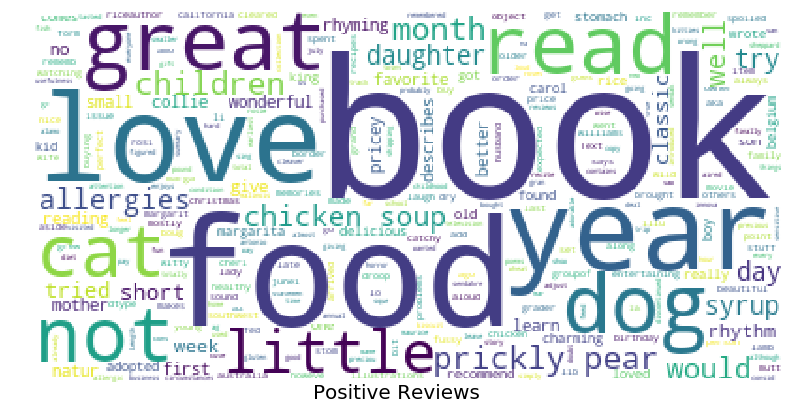

In [147]:
from wordcloud import WordCloud
import matplotlib as mpl

mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']= .1


wordcloud = WordCloud(stopwords=stopwords , background_color="white",max_words=370)
wordcloud.generate(str(data['Text'][:half_pts]))

title="Positive Reviews"
fig = plt.figure(1, figsize=(12, 8))
plt.axis('off')
 
fig.suptitle(title, fontsize=20)
fig.subplots_adjust(top=2.5)

plt.imshow(wordcloud)
plt.show()


In [148]:
data['Score'].value_counts()

1    25000
0    25000
Name: Score, dtype: int64

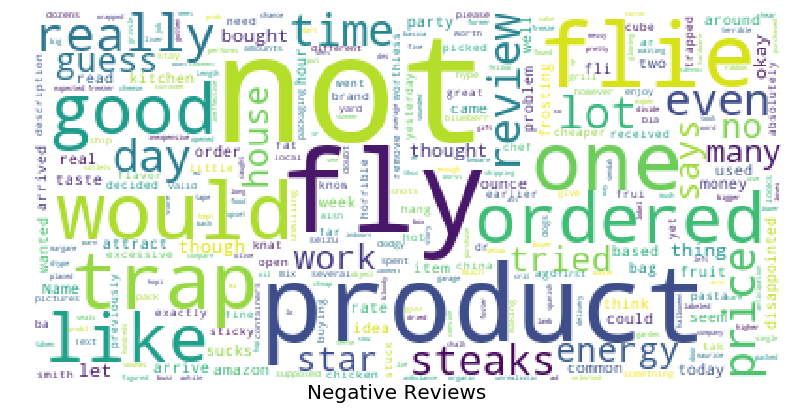

In [149]:
wordcloud = WordCloud(stopwords=stopwords , background_color="white",max_words=370)
wordcloud.generate(str(data['Text'][half_pts+1:]))

title="Negative Reviews"
fig = plt.figure(1, figsize=(12, 8))
plt.axis('off')
 
fig.suptitle(title, fontsize=20)
fig.subplots_adjust(top=2.5)

plt.imshow(wordcloud)
plt.show()

# [4] Featurization

### Data split into Train and Test set

In [150]:
from sklearn.model_selection import  train_test_split
x_temp , x_test_text , y_temp, y_test  = train_test_split(data['Text'] , data['Score'],
                                                         test_size=0.2,stratify=data['Score'],
                                                        random_state = 17)
print(x_temp.shape)
print(x_test_text.shape)
print(y_temp.shape)
print(y_test.shape)

(40000,)
(10000,)
(40000,)
(10000,)


In [151]:
x_train_text, x_cv_text , y_train , y_cv = train_test_split(x_temp , y_temp,
                                                           test_size=0.2,stratify = y_temp,
                                                        random_state = 17) 

In [152]:
print(x_train_text.shape)
print(x_cv_text.shape)
print(y_train.shape)
print(y_cv.shape)

(32000,)
(8000,)
(32000,)
(8000,)


## [4.1] BAG OF WORDS

In [153]:
# Original BOW Matrix for brute force KNN
bow = CountVectorizer()
text_train_bow = bow.fit_transform(x_train_text)
text_test_bow = bow.transform(x_test_text)
text_cv_bow = bow.transform(x_cv_text)
print("\nNumber of unique words: {} \n".format(text_train_bow.shape[1]))
print("Shape of Train DTM BOW Matrix : {}\n".format(text_train_bow.shape))
print("Shape of CV DTM BOW Matrix : {}\n".format(text_cv_bow.shape))
print("Shape of Test DTM BOW Matrix : {}\n".format(text_test_bow.shape))
print("Some of the features or words present in BOW matrix:\n {}".format(bow.get_feature_names()[2000:2010]))


Number of unique words: 37605 

Shape of Train DTM BOW Matrix : (32000, 37605)

Shape of CV DTM BOW Matrix : (8000, 37605)

Shape of Test DTM BOW Matrix : (10000, 37605)

Some of the features or words present in BOW matrix:
 ['athens', 'atherosclerosis', 'athlete', 'athletes', 'athletic', 'athrax', 'aticipation', 'atificial', 'atis', 'ativan']


In [154]:
less = 15000
data_pos_less = data[data['Score']==1][:less]
data_neg_less = data[data['Score']==0][:less]
data_less = pd.concat([data_pos_less,data_neg_less] ,axis=0)
print(data_less['Score'].value_counts())
data_less.shape

1    15000
0    15000
Name: Score, dtype: int64


(30000, 10)

In [155]:
x_temp_less , x_test_text_less , y_temp_less , y_test_less  = train_test_split(data_less['Text'] , data_less['Score'],
                                                         test_size=0.2,stratify=data_less['Score'],
                                                        random_state = 17)
print(x_temp_less.shape)
print(x_test_text_less.shape)
print(y_temp_less.shape)
print(y_test_less.shape)

(24000,)
(6000,)
(24000,)
(6000,)


In [156]:
x_train_text_less , x_cv_text_less , y_train_less , y_cv_less  = train_test_split(x_temp_less , y_temp_less,
                                                         test_size=0.2,stratify= y_temp_less,
                                                        random_state = 17)

In [157]:
print(x_train_text_less.shape)
print(x_cv_text_less.shape)
print(y_train_less.shape)
print(y_cv_less.shape)

(19200,)
(4800,)
(19200,)
(4800,)


In [158]:
#restricted one for kd-tree
bow_r = CountVectorizer(min_df=10, max_features=1000)
text_train_bow_r = bow_r.fit_transform(x_train_text_less)
text_test_bow_r = bow_r.transform(x_test_text_less)
text_cv_bow_r = bow_r.transform(x_cv_text_less)
print("\nNumber of unique words: {} \n".format(text_train_bow_r.shape[1]))
print("Shape of Train DTM BOW Restricted Matrix : {}\n".format(text_train_bow_r.shape))
print("Shape of CV DTM BOW Restricted Matrix : {}\n".format(text_cv_bow_r.shape))
print("Shape of Test DTM BOW Restricted Matrix : {}\n".format(text_test_bow_r.shape))
print("Some of the features or words present in BOW Restricted matrix:\n {}".format(bow_r.get_feature_names()[300:310]))


Number of unique words: 1000 

Shape of Train DTM BOW Restricted Matrix : (19200, 1000)

Shape of CV DTM BOW Restricted Matrix : (4800, 1000)

Shape of Test DTM BOW Restricted Matrix : (6000, 1000)

Some of the features or words present in BOW Restricted matrix:
 ['fantastic', 'far', 'farms', 'fast', 'fat', 'favorite', 'fed', 'feed', 'feeding', 'feel']


## [4.2] Bi-Grams and n-Grams.

In [159]:
#CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html


bow_gram = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
text_train_bow_gram = bow_gram.fit_transform(x_train_text)
text_test_bow_gram = bow_gram.transform(x_test_text)
print("\nNumber of unique words: {} \n".format(text_train_bow_gram.shape[1]))
print("Shape of Train DTM BOW GRAM Matrix : {}\n".format(text_train_bow_gram.shape))
print("Shape of Test DTM BOW GRAM Matrix : {}\n".format(text_test_bow_gram.shape))
print("Some of the features or words present in BOW_GRAM matrix:\n {}\n".format(bow_gram.get_feature_names()[2000:2010]))


Number of unique words: 5000 

Shape of Train DTM BOW GRAM Matrix : (32000, 5000)

Shape of Test DTM BOW GRAM Matrix : (10000, 5000)

Some of the features or words present in BOW_GRAM matrix:
 ['holes', 'holiday', 'holidays', 'holistic', 'home', 'home made', 'homemade', 'honest', 'honestly', 'honey']



## [4.3] TF-IDF

In [160]:
# Original TF-IDF Matrix for brute force KNN
tfidf = TfidfVectorizer()
text_train_tfidf = tfidf.fit_transform(x_train_text)
text_cv_tfidf = tfidf.transform(x_cv_text)
text_test_tfidf = tfidf.transform(x_test_text)

print("\nNumber of unique words: {} \n".format(text_train_tfidf.shape[1]))
print("Shape of Train DTM TF-IDF Matrix : {}\n".format(text_train_tfidf.shape))
print("Shape of CV DTM TF-IDF Matrix : {}\n".format(text_cv_tfidf.shape))
print("Shape of Test DTM TF-IDF Matrix : {}\n".format(text_test_tfidf.shape))

print("Some of the features or words present in TF-IDF matrix:\n {}\n".format(tfidf.get_feature_names()[2000:2010]))


Number of unique words: 37605 

Shape of Train DTM TF-IDF Matrix : (32000, 37605)

Shape of CV DTM TF-IDF Matrix : (8000, 37605)

Shape of Test DTM TF-IDF Matrix : (10000, 37605)

Some of the features or words present in TF-IDF matrix:
 ['athens', 'atherosclerosis', 'athlete', 'athletes', 'athletic', 'athrax', 'aticipation', 'atificial', 'atis', 'ativan']



In [161]:
#restricted one for kd tree(KNN)
tfidf_r = TfidfVectorizer(min_df=10 , max_features=1000)
text_train_tfidf_r = tfidf_r.fit_transform(x_train_text_less)
text_cv_tfidf_r = tfidf_r.transform(x_cv_text_less)
text_test_tfidf_r = tfidf_r.transform(x_test_text_less)

print("Number of unique words: {} \n".format(text_train_tfidf_r.shape[1]))
print("Shape of Train DTM TF-IDF Restricted Matrix : {}\n".format(text_train_tfidf_r.shape))
print("Shape of CV DTM TF-IDF Restricted Matrix : {}\n".format(text_cv_tfidf_r.shape))
print("Shape of Test DTM TF-IDF Restricted Matrix : {}\n".format(text_test_tfidf_r.shape))

print("Some of the features or words present in TF-IDF Restricted matrix:\n {}\n".format(tfidf_r.get_feature_names()[200:210]))

Number of unique words: 1000 

Shape of Train DTM TF-IDF Restricted Matrix : (19200, 1000)

Shape of CV DTM TF-IDF Restricted Matrix : (4800, 1000)

Shape of Test DTM TF-IDF Restricted Matrix : (6000, 1000)

Some of the features or words present in TF-IDF Restricted matrix:
 ['costs', 'could', 'couple', 'course', 'crackers', 'crazy', 'cream', 'creamy', 'crunchy', 'cup']



## [4.4] Word2Vec

In [52]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [53]:

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8486520051956177), ('awesome', 0.8472854495048523), ('fantastic', 0.8291192650794983), ('wonderful', 0.8184413313865662), ('excellent', 0.8055385947227478), ('perfect', 0.793589174747467), ('terrific', 0.7805633544921875), ('amazing', 0.7385966777801514), ('incredible', 0.7199898958206177), ('decent', 0.7113944888114929)]
[('nastiest', 0.8729661107063293), ('best', 0.7762337923049927), ('foulest', 0.7412693500518799), ('greatest', 0.7374513745307922), ('tastiest', 0.6952772736549377), ('nicest', 0.6661579608917236), ('disgusting', 0.6607877612113953), ('saltiest', 0.6539943218231201), ('finest', 0.6253733038902283), ('weakest', 0.6192953586578369)]


In [54]:
w2v_words = list(w2v_model.wv.vocab)
print("\n Number of words that occured minimum 5 times: ",len(w2v_words))
print("\n Sample words: ", w2v_words[0:50])


 Number of words that occured minimum 5 times:  20776

 Sample words:  ['sumptuous', 'fairy', 'pomeranians', 'feet', 'sterols', 'darn', 'knudsen', 'martinis', 'sweetend', 'block', 'shack', 'accidental', 'power', 'groomed', 'dissapointment', 'scraped', 'moscow', 'puttanesca', 'tags', 'inhaling', 'jug', 'paired', 'pulverized', 'bp', 'jumble', 'hatch', 'kippers', 'moss', 'due', 'emanating', 'matter', 'leukemia', 'envelops', 'powerfully', 'whatnot', 'delivers', 'glico', 'pomegranite', 'tin', 'zhejiang', 'monounsaturated', 'alas', 'ryan', 'mildest', 'justified', 'timeframe', 'mm', 'chicken', 'everlast', 'belly']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [55]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 112000/112000 [19:33<00:00, 95.44it/s] 

112000
50


In [2]:
# Loading the already pretrained word2vec by me on 112k data points 
#sent_vectors = np.array(sent_vectors)
sent_vectors = np.load('avg_w2v_112k.npy',)
print(type(sent_vectors))
print(sent_vectors.shape)

<class 'numpy.ndarray'>
(112000, 50)


In [3]:
# Loading the corresponding Y(target vector)
Y_112k = np.load('Y_112k.npy')
print(Y_112k.shape)

(112000,)


In [4]:
sent_vectors[12]

array([ 0.54566627,  0.57962064,  1.41445712,  0.23334496,  0.08682677,
        1.2635049 ,  0.63918633,  0.53985903, -0.65784386,  0.38373056,
       -0.02492389,  1.1557553 ,  0.03906789, -0.11450345, -0.5750305 ,
       -1.2300544 ,  0.02601699, -0.76819897, -0.78001904,  0.3724084 ,
        1.40840195, -1.29129876,  0.10126882,  1.02200326,  0.13128136,
       -0.18527924,  0.12039816, -0.09146577, -0.61417463, -0.07232044,
        0.29173207,  0.58884015,  0.04215739, -0.86832707,  0.20946081,
        0.39009336, -0.59924061, -0.23542879, -1.2105202 ,  0.29668606,
       -1.17814723, -1.1175144 , -0.03191684, -0.93224447,  1.07196052,
       -0.3231052 ,  2.26070916,  0.9098372 , -0.37106177, -0.9602194 ])

In [74]:
# Start of Avg W2V splitting for Brute
from sklearn.model_selection import train_test_split

x_m_t1 ,x_t1, y_m_t1 , y_t1 = train_test_split(sent_vectors, Y_112k, random_state=17,
                                               train_size = 0.44643,stratify = Y_112k )

print(x_m_t1.shape)
print(x_t1.shape)
print(y_m_t1.shape)
print(y_t1.shape)



(50000, 50)
(62000, 50)
(50000,)
(62000,)


In [75]:
x_train_avg_w2v ,x_cv_avg_w2v , y_train_avg_w2v , y_cv_avg_w2v = train_test_split(x_m_t1,y_m_t1,
                                                                                         random_state=17,
                                                                                         stratify=y_m_t1,train_size=0.8)




print((x_train_avg_w2v.shape))
print((x_cv_avg_w2v.shape))
print(y_train_avg_w2v.shape)
print(y_cv_avg_w2v.shape)


(40000, 50)
(10000, 50)
(40000,)
(10000,)


In [76]:
x_m_t2 , x_test_avg_w2v,y_m_t2, y_test_avg_w2v = train_test_split(x_t1,y_t1, random_state=17,
                                                                     stratify=y_t1, test_size=0.2)
print((x_test_avg_w2v.shape))
print(y_test_avg_w2v.shape)
# Splitting for Avg w2v for 112k data point is done Brute

(12400, 50)
(12400,)


In [7]:
# Start of Avg W2V splitting for kd (restriction)
x_m_t1 ,x_t1, y_m_t1 , y_t1 = train_test_split(sent_vectors, Y_112k, random_state=17,
                                               train_size = 0.22322,stratify = Y_112k )

print(x_m_t1.shape)
print(x_t1.shape)
print(y_m_t1.shape)
print(y_t1.shape)



(25000, 50)
(87000, 50)
(25000,)
(87000,)


In [8]:
x_train_avg_w2v_r , x_cv_avg_w2v_r, y_train_avg_w2v_r , y_cv_avg_w2v_r = train_test_split(x_m_t1,y_m_t1,
                                                                                         random_state=17,
                                                                                         stratify=y_m_t1,train_size=0.8)





print((x_train_avg_w2v_r.shape))
print((x_cv_avg_w2v_r.shape))
print(y_train_avg_w2v_r.shape)
print(y_cv_avg_w2v_r.shape)
print(x_train_avg_w2v_r[1].shape)
print(x_train_avg_w2v_r[1])

(20000, 50)
(5000, 50)
(20000,)
(5000,)
(50,)
[-0.38740907 -0.44823168  0.80565559 -0.66810747 -0.2350261   0.09223162
 -0.15589894 -0.40485605  0.83576464  0.23015524  0.06644448  0.7577373
  0.30415527 -0.3719346   0.22836703  1.39318485  0.79000827  0.96315587
 -0.29883906 -0.58708772  1.06319315  0.0366477   0.85317716  1.21226986
 -0.20796944  0.81226436 -0.51516131  0.91686057 -0.19958603  0.53868757
 -0.66047328  0.3682368   0.18964738 -0.33015437  0.53715775 -0.01115603
  0.10614186 -0.54375118 -0.64669845  0.68134447  0.27269955 -0.36236193
 -0.39606853 -0.07610589  0.46340051  1.19125287 -0.10090272 -1.00932498
  0.31550137  0.07957648]


In [9]:
x_m_t2 , x_test_avg_w2v_r,y_m_t2, y_test_avg_w2v_r = train_test_split(x_t1,y_t1, random_state=17,
                                                                     stratify=y_t1, test_size=0.066)
print((x_test_avg_w2v_r.shape))
print(y_test_avg_w2v_r.shape)
# End of Avg. W2V splitting for kd (restriction)

(5742, 50)
(5742,)


#### [4.4.1.2] TFIDF weighted W2v

In [62]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [63]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            #tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 112000/112000 [2:24:20<00:00, 10.35it/s]  


In [10]:
#tfidf_sent_vectors = np.save('tfidf_w2v_112k.npy',tfidf_sent_vectors)
# Loading the saved numpy array corresponding to tfidf_w2v for 112k data points
tfidf_sent_vectors = np.load('tfidf_w2v_112k.npy')
print(type(tfidf_sent_vectors))
print(tfidf_sent_vectors.shape)

<class 'numpy.ndarray'>
(112000, 50)


In [11]:
print(np.shape(tfidf_sent_vectors))

(112000, 50)


In [76]:
np.save('Y_112k.npy', data['Score'].values)

In [57]:
tfidf_sent_vectors[12]

array([ 0.54711787,  0.60223616,  1.40819736,  0.27280851,  0.13488345,
        1.20164469,  0.67656276,  0.71357152, -0.79420792,  0.39563968,
        0.16696807,  1.15678275,  0.00248748, -0.08184762, -0.6139074 ,
       -1.31004922, -0.13416027, -0.93993869, -0.84938581,  0.43816474,
        1.19391524, -1.17131365,  0.20961914,  1.03630273,  0.25308052,
       -0.27773593,  0.07546269, -0.08654847, -0.60337414, -0.03707421,
        0.28339744,  0.5749422 , -0.0840456 , -0.71823815, -0.0483419 ,
        0.16730889, -0.54686252, -0.16238314, -1.21340593,  0.26098442,
       -1.11801637, -1.03536586, -0.03993077, -0.8469635 ,  1.20799378,
       -0.40106539,  2.28153542,  0.91266582, -0.40429496, -0.85360115])

In [61]:
# Start of TFIDF W2V splitting for Brute

from sklearn.model_selection import train_test_split

x_m_t1 ,x_t1, y_m_t1 , y_t1 = train_test_split(tfidf_sent_vectors, Y_112k, random_state=17,
                                               train_size = 0.44643,stratify = Y_112k )

print(x_m_t1.shape)
print(x_t1.shape)
print(y_m_t1.shape)
print(y_t1.shape)



(50000, 50)
(62000, 50)
(50000,)
(62000,)


In [62]:
x_train_tfidf_w2v ,x_cv_tfidf_w2v , y_train_tfidf_w2v , y_cv_tfidf_w2v = train_test_split(x_m_t1,y_m_t1,
                                                                                         random_state=17,
                                                                                         stratify=y_m_t1,train_size=0.8)



   
    
print((x_train_tfidf_w2v.shape))
print((x_cv_tfidf_w2v.shape))
print(y_train_tfidf_w2v.shape)
print(y_cv_tfidf_w2v.shape)

(40000, 50)
(10000, 50)
(40000,)
(10000,)


In [68]:
x_m_t2 , x_test_tfidf_w2v,y_m_t2, y_test_tfidf_w2v = train_test_split(x_t1,y_t1, random_state=17,
                                                                     stratify=y_t1, test_size=0.2)
print((x_test_tfidf_w2v.shape))
print(y_test_tfidf_w2v.shape)
# Splitting for TFIDF w2v for 112k data point is done Brute

(12400, 50)
(12400,)


In [16]:
# Start of TFIDF W2V splitting for kd (restriction)
x_m_t1 ,x_t1, y_m_t1 , y_t1 = train_test_split(tfidf_sent_vectors, Y_112k, random_state=17,
                                               train_size = 0.22322,stratify = Y_112k)

print(x_m_t1.shape)
print(x_t1.shape)
print(y_m_t1.shape)
print(y_t1.shape)



(25000, 50)
(87000, 50)
(25000,)
(87000,)


In [17]:
x_train_tfidf_w2v_r , x_cv_tfidf_w2v_r, y_train_tfidf_w2v_r , y_cv_tfidf_w2v_r = train_test_split(x_m_t1,y_m_t1,
                                                                                         random_state=17,
                                                                                         stratify=y_m_t1,train_size=.8)

print((x_train_tfidf_w2v_r.shape))
print((x_cv_tfidf_w2v_r.shape))
print(y_train_tfidf_w2v_r.shape)
print(y_cv_tfidf_w2v_r.shape)
print(x_train_tfidf_w2v_r[1].shape)
print(x_train_tfidf_w2v_r[1])

(20000, 50)
(5000, 50)
(20000,)
(5000,)
(50,)
[-0.49241636 -0.49353564  0.75910719 -0.74436273 -0.32909498 -0.01953859
 -0.01268865 -0.49137221  0.79717202  0.15505742  0.03564421  0.55359567
  0.49678132 -0.23181979  0.29364581  1.37492958  0.65507743  1.02586653
 -0.19114352 -0.55097815  0.82399255  0.03067716  0.82841869  1.13136897
 -0.25207596  1.13075083 -0.8146032   0.96852104 -0.1286951   0.71780462
 -0.7839823   0.37856378  0.03691498 -0.27025683  0.30310592  0.08914159
  0.32027017 -0.57262497 -0.64113925  0.47258081  0.3888981  -0.56317929
 -0.44877833 -0.00910462  0.60686632  1.17496659 -0.0899078  -1.11093086
  0.27733851  0.11187375]


In [18]:
x_m_t2 , x_test_tfidf_w2v_r,y_m_t2, y_test_tfidf_w2v_r = train_test_split(x_t1,y_t1, random_state=17,
                                                                     stratify=y_t1, test_size=0.066)
print((x_test_tfidf_w2v_r.shape))
print(y_test_tfidf_w2v_r.shape)
# End of TFIDF W2V splitting for kd (restriction)

(5742, 50)
(5742,)


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [19]:
# (Plot Mean Train and Test metric on the same graph ) Do this for every metric
def plot_cv(result ,scoring_dict, parameters,title):
    plt.style.use('fivethirtyeight')
    if len(parameters)==1:
        for keys in scoring_dict.keys():
            fig = plt.figure(figsize=(9,6))
            param_name = (list(parameters.keys()))[0]
            values_of_hp = [dic[keys_] for dic in result['params'] for keys_ in dic.keys()]
            #values_of_hp=[list(dic.values())[0] for dic in result['params']],can also be used
            #But it is only specific to 1 parameter and not general one
            plt.plot(values_of_hp , result['mean_train_'+keys], color='blue',label ="Train "+keys)
            plt.plot(values_of_hp , result['mean_test_'+keys],color='red',label='CV '+keys)
            plt.legend() 
            plt.xlabel(param_name)
            plt.ylabel(keys)
            plt.title("Performance of "+keys+ " using " + title)
            plt.show()
    else:
        print('Currently, Function is not defined for more than 1 Hyper parameters')

In [32]:
# Function which will be used for cross validation
# Most important function which will be used in hyperparameter selection
def training(x_train,y_train,x_cv,y_cv,parameter,algo):
    train_auc = {}
    train_acc = {}
    train_f1 =  {}
    cv_auc = {}
    cv_acc= {}
    cv_f1 = {}
    for i in parameter:
        print("Training for Parameter: {}".format(i))
        clf = KNeighborsClassifier(n_neighbors=i,algorithm=algo)
        clf.fit(x_train,y_train)
        train_prob = clf.predict_proba(x_train)
        cv_prob = clf.predict_proba(x_cv)
        train_pred = clf.predict(x_train)
        cv_pred = clf.predict(x_cv)
        train_auc[i] = roc_auc_score(y_train , train_prob[:,1])
        cv_auc[i] = roc_auc_score(y_cv , cv_prob[:,1])
        train_acc[i] = accuracy_score(y_train , train_pred)
        cv_acc[i] = accuracy_score(y_cv , cv_pred)
        train_f1[i] = f1_score(y_train , train_pred)
        cv_f1[i] = f1_score(y_cv , cv_pred)
        print("Train AUC for {} parameter: {}".format(i,train_auc[i]))
        print("CV AUC for {} parameter: {}".format(i,cv_auc[i]))
        print("Train Accuracy for {} parameter: {}".format(i,train_acc[i]))
        print("CV Accuracy for {} parameter: {}".format(i,cv_acc[i]))
        print("Train F1 Score for {} parameter: {}".format(i,train_f1[i]))
        print("CV F1 Score for {} parameter: {}".format(i,cv_f1[i]))
        print("-"*80)
    return (train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1) 

In [31]:
# Silightly modified version of above function
def modified_training(x_train,y_train,x_cv,y_cv,parameter,algo,train_auc,train_acc,train_f1,cv_auc,cv_acc,cv_f1):
    for i in parameter:
        print("Training for Parameter: {}".format(i))
        clf = KNeighborsClassifier(n_neighbors=i,algorithm=algo)
        clf.fit(x_train,y_train)
        train_prob = clf.predict_proba(x_train)
        cv_prob = clf.predict_proba(x_cv)
        train_pred = clf.predict(x_train)
        cv_pred = clf.predict(x_cv)
        train_auc[i] = roc_auc_score(y_train , train_prob[:,1])
        cv_auc[i] = roc_auc_score(y_cv , cv_prob[:,1])
        train_acc[i] = accuracy_score(y_train , train_pred)
        cv_acc[i] = accuracy_score(y_cv , cv_pred)
        train_f1[i] = f1_score(y_train , train_pred)
        cv_f1[i] = f1_score(y_cv , cv_pred)
        print("Train AUC for {} parameter: {}".format(i,train_auc[i]))
        print("CV AUC for {} parameter: {}".format(i,cv_auc[i]))
        print("Train Accuracy for {} parameter: {}".format(i,train_acc[i]))
        print("CV Accuracy for {} parameter: {}".format(i,cv_acc[i]))
        print("Train F1 Score for {} parameter: {}".format(i,train_f1[i]))
        print("CV F1 Score for {} parameter: {}".format(i,cv_f1[i]))
        print("-"*80)
    return (train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1) 

In [21]:
# Function which will be used for plotting the matrices recorded during cross validation
def plotting_plot(train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1,str1,str2):
    fig = plt.figure(1)
    plt.plot(train_auc.keys() , train_auc.values(),color='blue',label='Train AUC')
    plt.plot(cv_auc.keys(), cv_auc.values(),color='red',label='CV AUC')
    plt.xlabel("Neighbor")
    plt.ylabel("AUC")
    plt.legend()
    plt.title("Performance:AUC KNN" + str1+"on"+str2)
    plt.show()
    
    fig = plt.figure(2)
    plt.plot(train_acc.keys() , train_acc.values(),color='blue',label='Train ACC')
    plt.plot(cv_acc.keys(), cv_acc.values(),color='red',label='CV ACC')
    plt.xlabel("Neighbor")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Performance:Accuracy-KNN"+str1+"on"+str2)
    plt.show()
    
    fig = plt.figure(3)
    plt.plot(train_f1.keys() , train_f1.values(),color='blue',label='Train F1')
    plt.plot(cv_f1.keys(), cv_f1.values(),color='red',label='CV F1')
    plt.xlabel("Neighbor")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.title("Performance:F1 Score-KNN" +str1 + "on"+str2)
    plt.show()    

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [22]:
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score , accuracy_score,make_scorer ,roc_curve, confusion_matrix,f1_score

In [46]:
#parameter holds the value of hyperparameter to be tried
parameter = [i for i in range(3,16,2)]
train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1= training(text_train_bow,y_train,
                                                           text_cv_bow,y_cv,parameter,'brute')

Training for Parameter: 3
Train AUC for 3 parameter: 0.9234371700178698
CV AUC for 3 parameter: 0.7343720093927222
Train Accuracy for 3 parameter: 0.8627038043478261
CV Accuracy for 3 parameter: 0.6764945652173913
Train F1 Score for 3 parameter: 0.8610041265474552
CV F1 Score for 3 parameter: 0.6473115094060139
--------------------------------------------------------------------------------
Training for Parameter: 5
Train AUC for 5 parameter: 0.8784295965818467
CV AUC for 5 parameter: 0.7433161773393195
Train Accuracy for 5 parameter: 0.7948709239130435
CV Accuracy for 5 parameter: 0.6819293478260869
Train F1 Score for 5 parameter: 0.7853868296670101
CV F1 Score for 5 parameter: 0.6624369142033165
--------------------------------------------------------------------------------
Training for Parameter: 7
Train AUC for 7 parameter: 0.8600811248375473
CV AUC for 7 parameter: 0.7488945829395086
Train Accuracy for 7 parameter: 0.7743885869565217
CV Accuracy for 7 parameter: 0.68125
Train F1 

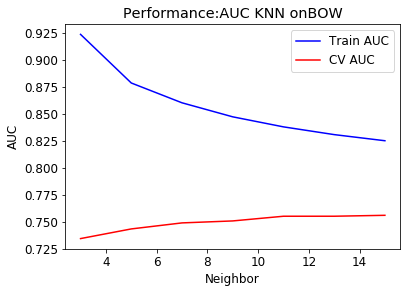

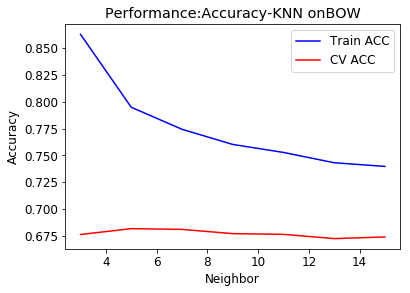

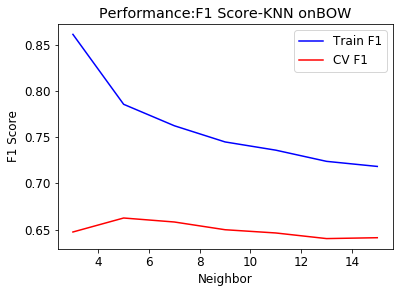

In [47]:
plotting_plot(train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1," ",'BOW')

### Observation:
- From the above graph and output of training function, it can be easily observed that parameter(n_neighbors=9) is optimal as for this parameter the difference between train score and cv score is minimum out of every parameter and the cv score is also high for this paramter which implies that our model is neither overfit nor underfit for this parameter. 

In [109]:
'''
CHOOSE YOUR BEST MODEL HERE
'''
print(train_auc)
print(cv_auc)
algo = 'brute'
best_clf = KNeighborsClassifier(n_neighbors=9,algorithm=algo)
#print("\nBest Parameter:\n {}".format(gs.best_params_))
best_clf.fit(text_train_bow , y_train)
train_pred = best_clf.predict(text_train_bow)

train_proba = best_clf.predict_proba(text_train_bow)
test_pred = best_clf.predict(text_test_bow)
test_proba = best_clf.predict_proba(text_test_bow)
print(" AUC: {}".format(roc_auc_score(y_test,test_pred)))
print(" Accuracy: {}".format(accuracy_score(y_test,test_pred)))
print(" F1 Score: {}".format(f1_score(y_test,test_pred)))
#roc_curve(y_train , train_pred)

{3: 0.9234371700178698, 5: 0.8784295965818467, 7: 0.8600811248375473, 9: 0.8470999324344282, 11: 0.8378069341475662, 13: 0.8306362701589083, 15: 0.8249645603807301}
{3: 0.7343720093927222, 5: 0.7433161773393195, 7: 0.7488945829395086, 9: 0.7507181518785444, 11: 0.7550591844872401, 13: 0.7550728452859169, 15: 0.7559242453331758}
 AUC: 0.6892999999999999
 Accuracy: 0.6893
 F1 Score: 0.6680910159171028


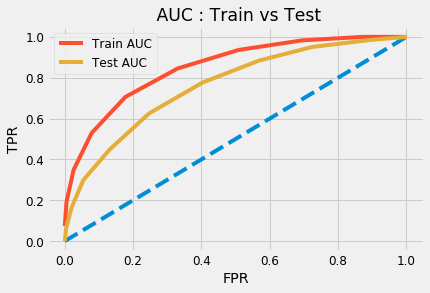

In [110]:
fpr_train , tpr_train ,thresholds = roc_curve(y_train,train_proba[:,1],pos_label=1) 
fpr_test , tpr_test ,thresholds = roc_curve(y_test,test_proba[:,1],pos_label=1) 
plt.plot([0,1],[0,1],'--')
plt.plot(fpr_train,tpr_train,label='Train AUC')
plt.plot(fpr_test,tpr_test,label='Test AUC')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(" AUC : Train vs Test")
plt.show()

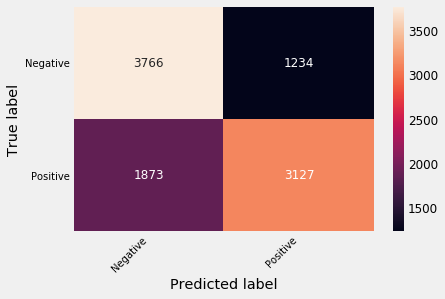

In [111]:
classes = ['Negative','Positive']
from seaborn import heatmap
C = confusion_matrix(y_test , test_pred)
fontsize = 10
df_cm = pd.DataFrame(
        C, index=classes, columns=classes, 
    )
fig = plt.figure()
try:
  heatmap_ = heatmap(df_cm, annot=True, fmt="d")
except ValueError:
  raise ValueError("Confusion matrix values must be integers.")
heatmap_.yaxis.set_ticklabels(heatmap_.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap_.xaxis.set_ticklabels(heatmap_.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [54]:



parameter = [i for i in range(3,16,2)]
train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1= training(text_train_tfidf,y_train,
                                                           text_cv_tfidf,y_cv,parameter,'brute')


Training for Parameter: 3
Train AUC for 3 parameter: 0.9620422940173086
CV AUC for 3 parameter: 0.5887328316989604
Train Accuracy for 3 parameter: 0.9548913043478261
CV Accuracy for 3 parameter: 0.5691576086956521
Train F1 Score for 3 parameter: 0.9554631430679456
CV F1 Score for 3 parameter: 0.35404359339987773
--------------------------------------------------------------------------------
Training for Parameter: 5
Train AUC for 5 parameter: 0.7960700420531073
CV AUC for 5 parameter: 0.5807116168478261
Train Accuracy for 5 parameter: 0.7249660326086956
CV Accuracy for 5 parameter: 0.5528532608695652
Train F1 Score for 5 parameter: 0.7132282627944042
CV F1 Score for 5 parameter: 0.5284424702679467
--------------------------------------------------------------------------------
Training for Parameter: 7
Train AUC for 7 parameter: 0.7616237543751477
CV AUC for 7 parameter: 0.5767672273747637
Train Accuracy for 7 parameter: 0.6926290760869566
CV Accuracy for 7 parameter: 0.54904891304347

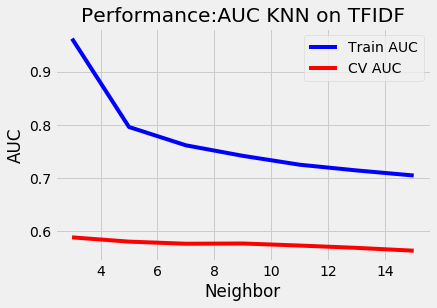

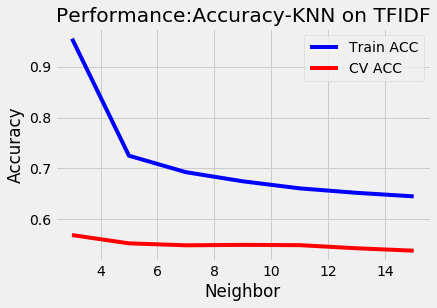

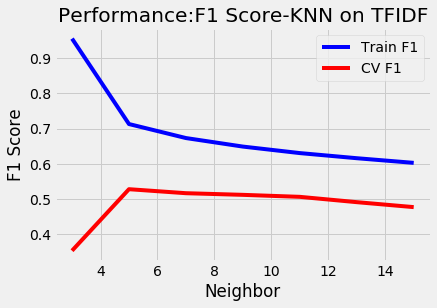

In [55]:
plt.style.use('fivethirtyeight')
plotting_plot(train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1," ",' TFIDF')

### Observation:
- From the above graph and output of training function, it can be easily observed that parameter(n_neighbors=5) is optimal as for this parameter the difference between train score and cv score is minimum out of every parameter and the cv score is also high for this paramter which implies that our model is neither overfit nor underfit for this parameter. 

In [113]:
'''
CHOOSE YOUR BEST MODEL HERE
'''
print(train_auc)
print(cv_auc)
algo = 'brute'
best_clf = KNeighborsClassifier(n_neighbors=5,algorithm=algo)
#print("\nBest Parameter:\n {}".format(gs.best_params_))
best_clf.fit(text_train_tfidf , y_train)

train_pred = best_clf.predict(text_train_tfidf)
train_proba = best_clf.predict_proba(text_train_tfidf)
test_pred = best_clf.predict(text_test_tfidf)
test_proba = best_clf.predict_proba(text_test_tfidf)

print(" AUC: {}".format(roc_auc_score(y_test,test_pred)))
print(" Accuracy: {}".format(accuracy_score(y_test,test_pred)))
print(" F1 Score: {}".format(f1_score(y_test,test_pred)))




{3: 0.9620422940173086, 5: 0.7960700420531073, 7: 0.7616237543751477, 9: 0.7418454723682655, 11: 0.7251500495665465, 13: 0.7144252726621574, 15: 0.704924242564095}
{3: 0.5887328316989604, 5: 0.5807116168478261, 7: 0.5767672273747637, 9: 0.5772161138350661, 11: 0.5733379607750472, 13: 0.5690091859640833, 15: 0.5636823605860113}
 AUC: 0.5576000000000001
 Accuracy: 0.5576
 F1 Score: 0.5454171804356761


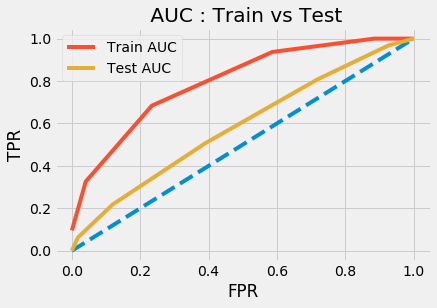

In [59]:
fpr_train , tpr_train ,thresholds = roc_curve(y_train,train_proba[:,1],pos_label=1) 
fpr_test , tpr_test ,thresholds = roc_curve(y_test,test_proba[:,1],pos_label=1) 
plt.plot([0,1],[0,1],'--')
plt.plot(fpr_train,tpr_train,label='Train AUC')
plt.plot(fpr_test,tpr_test,label='Test AUC')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(" AUC : Train vs Test")
plt.show()

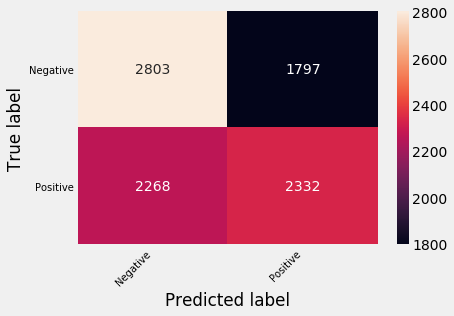

In [60]:

C = confusion_matrix(y_test , test_pred)
fontsize = 10
df_cm = pd.DataFrame(
        C, index=classes, columns=classes, 
    )
fig = plt.figure()
try:
  heatmap_ = heatmap(df_cm, annot=True, fmt="d")
except ValueError:
  raise ValueError("Confusion matrix values must be integers.")
heatmap_.yaxis.set_ticklabels(heatmap_.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap_.xaxis.set_ticklabels(heatmap_.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [114]:
del text_cv_bow,text_train_bow,text_test_bow

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [55]:





parameter = [i for i in range(3,17,2)]
train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1= training(x_train_avg_w2v , y_train_avg_w2v,
                                                           x_cv_avg_w2v , y_cv_avg_w2v,parameter,'brute')





Training for Parameter: 3
Train AUC for 3 parameter: 0.95432374
CV AUC for 3 parameter: 0.8388710000000001
Train Accuracy for 3 parameter: 0.8854
CV Accuracy for 3 parameter: 0.7836
Train F1 Score for 3 parameter: 0.8836548223350253
CV F1 Score for 3 parameter: 0.7785962758338448
--------------------------------------------------------------------------------
Training for Parameter: 5
Train AUC for 5 parameter: 0.94092271375
CV AUC for 5 parameter: 0.86471248
Train Accuracy for 5 parameter: 0.8632
CV Accuracy for 5 parameter: 0.7975
Train F1 Score for 5 parameter: 0.8607562725838465
CV F1 Score for 5 parameter: 0.7937671860678277
--------------------------------------------------------------------------------
Training for Parameter: 7
Train AUC for 7 parameter: 0.9332011699999999
CV AUC for 7 parameter: 0.87687878
Train Accuracy for 7 parameter: 0.85345
CV Accuracy for 7 parameter: 0.8058
Train F1 Score for 7 parameter: 0.8504896959804122
CV F1 Score for 7 parameter: 0.8011061040557148

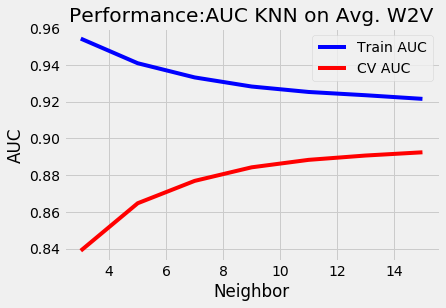

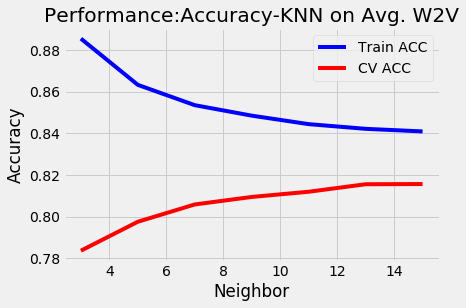

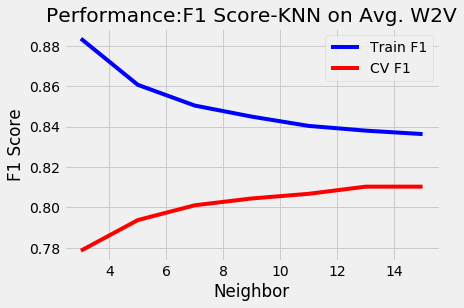

In [56]:
plt.style.use('fivethirtyeight')
plotting_plot(train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1," ",' Avg. W2V')

### Observation:
- From the above graph and output of training function, it can be easily observed that parameter(n_neighbors=13) is optimal as for this parameter the difference between train score and cv score is minimum out of every parameter and the cv score is also high for this paramter which implies that our model is neither overfit nor underfit for this parameter. 

In [78]:
'''
CHOOSE YOUR BEST MODEL HERE
'''
print(train_auc)
print(cv_auc)
algo = 'brute'
best_clf = KNeighborsClassifier(n_neighbors=13,algorithm=algo)


best_clf.fit(x_train_avg_w2v , y_train_avg_w2v)

train_pred = best_clf.predict(x_train_avg_w2v )
train_proba = best_clf.predict_proba(x_train_avg_w2v )
test_pred = best_clf.predict(x_test_avg_w2v )
test_proba = best_clf.predict_proba(x_test_avg_w2v )


print(" AUC: {}".format(roc_auc_score(y_test_avg_w2v,test_pred)))
print(" Accuracy: {}".format(accuracy_score(y_test_avg_w2v,test_pred)))
print(" F1 Score: {}".format(f1_score(y_test_avg_w2v,test_pred)))





{3: 0.94306869875, 5: 0.9266458575000001, 7: 0.9174188225, 9: 0.91055089625, 11: 0.90662160125, 13: 0.9037333725000001, 15: 0.9018420112500002}
{3: 0.81192776, 5: 0.83637262, 7: 0.8466750000000001, 9: 0.8544053200000001, 11: 0.85850054, 13: 0.8603317, 15: 0.86266676}
 AUC: 0.8099999999999999
 Accuracy: 0.81
 F1 Score: 0.8039933444259566


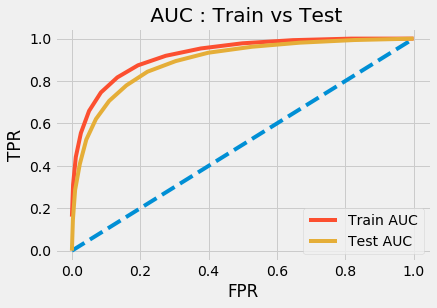

In [79]:
fpr_train , tpr_train ,thresholds = roc_curve(y_train_avg_w2v,train_proba[:,1],pos_label=1) 
fpr_test , tpr_test ,thresholds = roc_curve(y_test_avg_w2v,test_proba[:,1],pos_label=1) 
plt.plot([0,1],[0,1],'--')
plt.plot(fpr_train,tpr_train,label='Train AUC')
plt.plot(fpr_test,tpr_test,label='Test AUC')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(" AUC : Train vs Test")
plt.show()

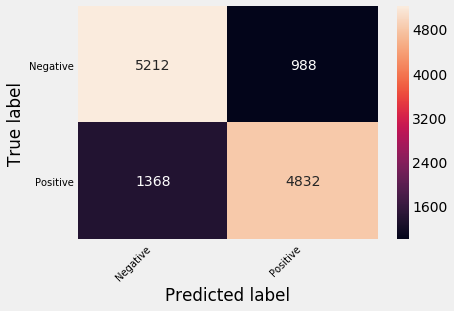

In [80]:
classes = ['Negative','Positive']
C = confusion_matrix(y_test_avg_w2v , test_pred)
fontsize = 10
df_cm = pd.DataFrame(
        C, index=classes, columns=classes, 
    )
fig = plt.figure()
try:
  heatmap_ = heatmap(df_cm, annot=True, fmt="d")
except ValueError:
  raise ValueError("Confusion matrix values must be integers.")
heatmap_.yaxis.set_ticklabels(heatmap_.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap_.xaxis.set_ticklabels(heatmap_.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [63]:





parameter = [i for i in range(3,17,2)]
train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1= training(x_train_tfidf_w2v , y_train_tfidf_w2v,
                                                           x_cv_tfidf_w2v , y_cv_tfidf_w2v,parameter,'brute')





Training for Parameter: 3
Train AUC for 3 parameter: 0.94306869875
CV AUC for 3 parameter: 0.81192776
Train Accuracy for 3 parameter: 0.872025
CV Accuracy for 3 parameter: 0.7595
Train F1 Score for 3 parameter: 0.8707943158585528
CV F1 Score for 3 parameter: 0.7569970698191371
--------------------------------------------------------------------------------
Training for Parameter: 5
Train AUC for 5 parameter: 0.9266458575000001
CV AUC for 5 parameter: 0.83637262
Train Accuracy for 5 parameter: 0.84755
CV Accuracy for 5 parameter: 0.7707
Train F1 Score for 5 parameter: 0.8465216953589046
CV F1 Score for 5 parameter: 0.7697559995983533
--------------------------------------------------------------------------------
Training for Parameter: 7
Train AUC for 7 parameter: 0.9174188225
CV AUC for 7 parameter: 0.8466750000000001
Train Accuracy for 7 parameter: 0.836575
CV Accuracy for 7 parameter: 0.7743
Train F1 Score for 7 parameter: 0.8353110120172322
CV F1 Score for 7 parameter: 0.7729604667

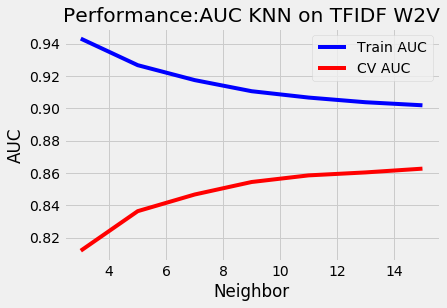

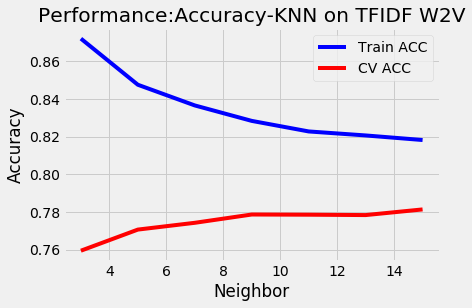

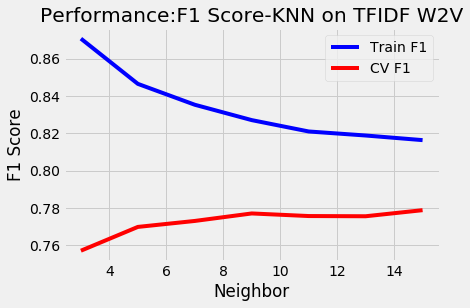

In [64]:
plt.style.use('fivethirtyeight')
plotting_plot(train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1," ",' TFIDF W2V')

### Observation:
- From the above graph and output of training function, it can be easily observed that parameter(n_neighbors=13) is optimal as for this parameter the difference between train score and cv score is minimum out of every parameter and the cv score is also high for this paramter which implies that our model is neither overfit nor underfit for this parameter. 

In [70]:
'''
CHOOSE YOUR BEST MODEL HERE
'''
print(train_auc)
print(cv_auc)
algo = 'brute'
best_clf = KNeighborsClassifier(n_neighbors=13,algorithm=algo)


best_clf.fit(x_train_tfidf_w2v , y_train_tfidf_w2v)


train_pred = best_clf.predict(x_train_tfidf_w2v )
train_proba = best_clf.predict_proba(x_train_tfidf_w2v )
test_pred = best_clf.predict(x_test_tfidf_w2v )
test_proba = best_clf.predict_proba(x_test_tfidf_w2v )

print(" AUC: {}".format(roc_auc_score(y_test_tfidf_w2v,test_pred)))
print(" Accuracy: {}".format(accuracy_score(y_test_tfidf_w2v,test_pred)))
print(" F1 Score: {}".format(f1_score(y_test_tfidf_w2v,test_pred)))


{3: 0.94306869875, 5: 0.9266458575000001, 7: 0.9174188225, 9: 0.91055089625, 11: 0.90662160125, 13: 0.9037333725000001, 15: 0.9018420112500002}
{3: 0.81192776, 5: 0.83637262, 7: 0.8466750000000001, 9: 0.8544053200000001, 11: 0.85850054, 13: 0.8603317, 15: 0.86266676}
 AUC: 0.7828225806451613
 Accuracy: 0.7828225806451613
 F1 Score: 0.7807895807895808


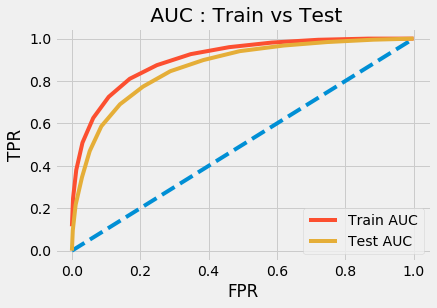

In [71]:
fpr_train , tpr_train ,thresholds = roc_curve(y_train_tfidf_w2v,train_proba[:,1],pos_label=1) 
fpr_test , tpr_test ,thresholds = roc_curve(y_test_tfidf_w2v,test_proba[:,1],pos_label=1) 
plt.plot([0,1],[0,1],'--')
plt.plot(fpr_train,tpr_train,label='Train AUC')
plt.plot(fpr_test,tpr_test,label='Test AUC')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(" AUC : Train vs Test")
plt.show()

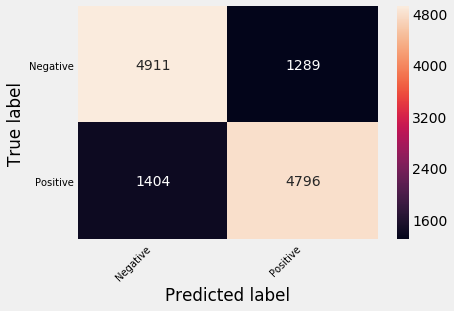

In [72]:

C = confusion_matrix(y_test_tfidf_w2v , test_pred)
fontsize = 10
df_cm = pd.DataFrame(
        C, index= classes, columns= classes, 
    )
fig = plt.figure()
try:
  heatmap_ = heatmap(df_cm, annot=True, fmt="d")
except ValueError:
  raise ValueError("Confusion matrix values must be integers.")
heatmap_.yaxis.set_ticklabels(heatmap_.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap_.xaxis.set_ticklabels(heatmap_.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [50]:
text_train_bow_r = text_train_bow_r.todense()
text_cv_bow_r = text_cv_bow_r.todense()

In [53]:



parameter = [i for i in range(3,16,2)]
train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1= training(text_train_bow_r,y_train_less,
                                                           text_cv_bow_r,y_cv_less,parameter,'kd_tree')


Training for Parameter: 3
Train AUC for 3 parameter: 0.8986140896267361
CV AUC for 3 parameter: 0.717585763888889
Train Accuracy for 3 parameter: 0.81546875
CV Accuracy for 3 parameter: 0.678125
Train F1 Score for 3 parameter: 0.8132609497707267
CV F1 Score for 3 parameter: 0.6773856755063687
--------------------------------------------------------------------------------
Training for Parameter: 5
Train AUC for 5 parameter: 0.8658154513888888
CV AUC for 5 parameter: 0.7455340277777778
Train Accuracy for 5 parameter: 0.7819791666666667
CV Accuracy for 5 parameter: 0.69625
Train F1 Score for 5 parameter: 0.7792892544553411
CV F1 Score for 5 parameter: 0.6952341137123745
--------------------------------------------------------------------------------
Training for Parameter: 7
Train AUC for 7 parameter: 0.8499496744791666
CV AUC for 7 parameter: 0.7567828125
Train Accuracy for 7 parameter: 0.7676041666666666
CV Accuracy for 7 parameter: 0.6970833333333334
Train F1 Score for 7 parameter: 0.

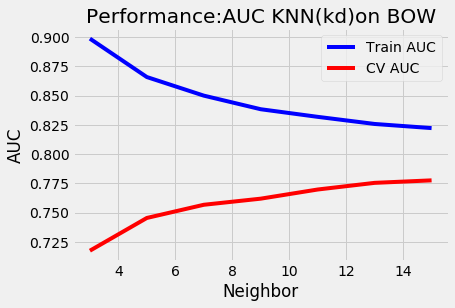

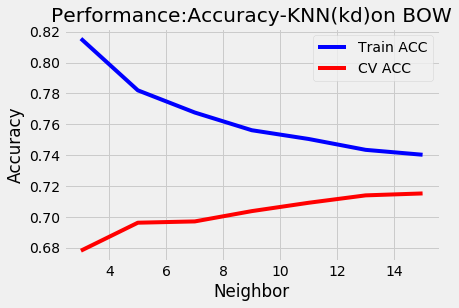

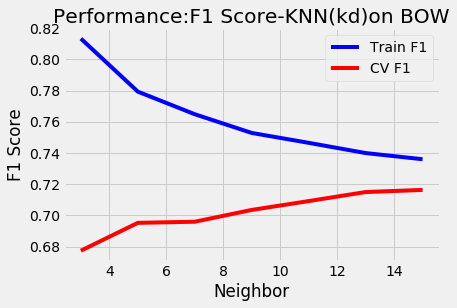

In [54]:
plt.style.use('fivethirtyeight')
plotting_plot(train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1,"(kd)",' BOW')

In [55]:
text_test_bow_r = text_test_bow_r.todense()

### Observation:
- From the above graph and output of training function, it can be easily observed that parameter(n_neighbors=11) is optimal as for this parameter the difference between train score and cv score is minimum out of every parameter and the cv score is also high for this paramter which implies that our model is neither overfit nor underfit for this parameter. 

In [57]:
'''
CHOOSE YOUR BEST MODEL HERE
'''
print(train_auc)
print(cv_auc)
algo = 'kd_tree'
best_clf = KNeighborsClassifier(n_neighbors=11,algorithm=algo)


best_clf.fit(text_train_bow_r , y_train_less)

train_pred = best_clf.predict(text_train_bow_r)
train_proba = best_clf.predict_proba(text_train_bow_r)
test_pred = best_clf.predict(text_test_bow_r)
test_proba = best_clf.predict_proba(text_test_bow_r)


print(" AUC: {}".format(roc_auc_score(y_test_less,test_pred)))
print(" Accuracy: {}".format(accuracy_score(y_test_less,test_pred)))
print(" F1 Score: {}".format(f1_score(y_test_less,test_pred)))




{3: 0.8986140896267361, 5: 0.8658154513888888, 7: 0.8499496744791666, 9: 0.8383384223090277, 11: 0.8318453993055556, 13: 0.8257652343749999, 15: 0.822239892578125}
{3: 0.717585763888889, 5: 0.7455340277777778, 7: 0.7567828125, 9: 0.7620022569444445, 11: 0.7698146701388888, 13: 0.7754927083333334, 15: 0.7776315972222223}
 AUC: 0.6951666666666667
 Accuracy: 0.6951666666666667
 F1 Score: 0.6919319521643927


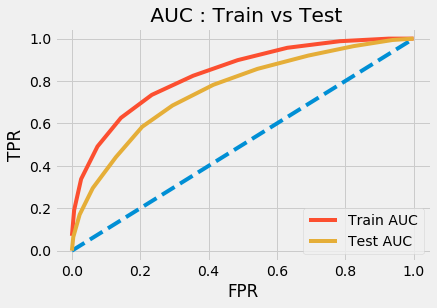

In [58]:
fpr_train , tpr_train ,thresholds = roc_curve(y_train_less,train_proba[:,1],pos_label=1) 
fpr_test , tpr_test ,thresholds = roc_curve(y_test_less,test_proba[:,1],pos_label=1) 
plt.plot([0,1],[0,1],'--')
plt.plot(fpr_train,tpr_train,label='Train AUC')
plt.plot(fpr_test,tpr_test,label='Test AUC')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(" AUC : Train vs Test")
plt.show()

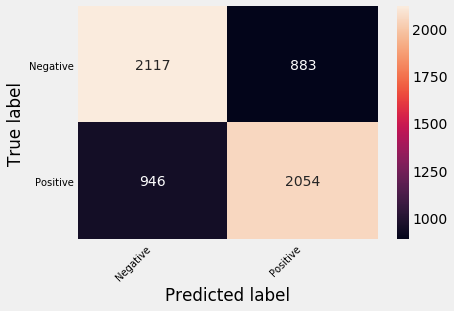

In [61]:
classes = ['Negative','Positive']
from seaborn import heatmap
C = confusion_matrix(y_test_less , test_pred)
fontsize = 10
df_cm = pd.DataFrame(
        C, index=classes, columns=classes, 
    )
fig = plt.figure()
try:
  heatmap_ = heatmap(df_cm, annot=True, fmt="d")
except ValueError:
  raise ValueError("Confusion matrix values must be integers.")
heatmap_.yaxis.set_ticklabels(heatmap_.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap_.xaxis.set_ticklabels(heatmap_.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [62]:
del text_train_bow_r,text_cv_bow_r,text_test_bow_r

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [63]:
text_train_tfidf_r = text_train_tfidf_r.todense()
text_cv_tfidf_r = text_cv_tfidf_r.todense()

In [64]:



parameter = [i for i in range(3,15,2)]
train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1= training(text_train_tfidf_r,y_train_less,
                                                           text_cv_tfidf_r,y_cv_less,parameter,'kd_tree')


Training for Parameter: 3
Train AUC for 3 parameter: 0.9027377604166666
CV AUC for 3 parameter: 0.7200018229166667
Train Accuracy for 3 parameter: 0.8277604166666667
CV Accuracy for 3 parameter: 0.676875
Train F1 Score for 3 parameter: 0.8274098429100778
CV F1 Score for 3 parameter: 0.6780153622586672
--------------------------------------------------------------------------------
Training for Parameter: 5
Train AUC for 5 parameter: 0.8731462185329861
CV AUC for 5 parameter: 0.7431379340277777
Train Accuracy for 5 parameter: 0.7940104166666667
CV Accuracy for 5 parameter: 0.688125
Train F1 Score for 5 parameter: 0.7933322882374458
CV F1 Score for 5 parameter: 0.6907663705845899
--------------------------------------------------------------------------------
Training for Parameter: 7
Train AUC for 7 parameter: 0.8576670789930555
CV AUC for 7 parameter: 0.7562460069444445
Train Accuracy for 7 parameter: 0.7794270833333333
CV Accuracy for 7 parameter: 0.68875
Train F1 Score for 7 paramete

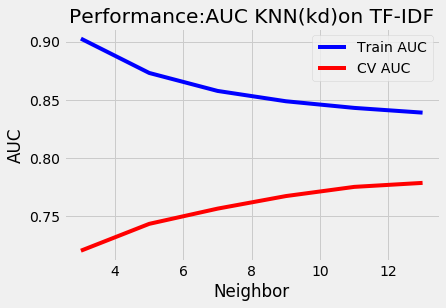

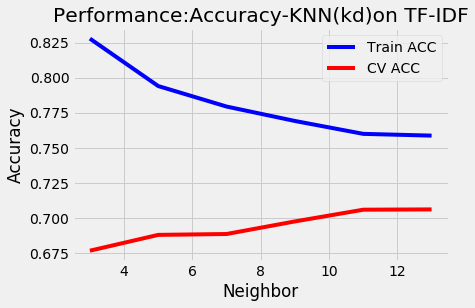

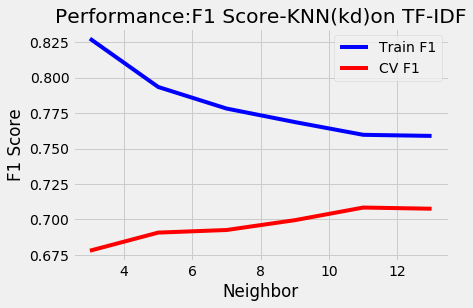

In [65]:
plt.style.use('fivethirtyeight')
plotting_plot(train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1,"(kd)",' TF-IDF')

In [66]:
text_test_tfidf_r = text_test_tfidf_r.todense()

### Observation:
- From the above graph and output of training function, it can be easily observed that parameter(n_neighbors=11) is optimal as for this parameter the difference between train score and cv score is minimum out of every parameter and the cv score is also high for this paramter which implies that our model is neither overfit nor underfit for this parameter. 

In [68]:
'''
CHOOSE YOUR BEST MODEL HERE
'''
print(train_auc)
print(cv_auc)
algo = 'kd_tree'
best_clf = KNeighborsClassifier(n_neighbors=11,algorithm=algo)


best_clf.fit(text_train_tfidf_r , y_train_less)

train_pred = best_clf.predict(text_train_tfidf_r)
train_proba = best_clf.predict_proba(text_train_tfidf_r)
test_pred = best_clf.predict(text_test_tfidf_r)
test_proba = best_clf.predict_proba(text_test_tfidf_r)


print(" AUC: {}".format(roc_auc_score(y_test_less,test_pred)))
print(" Accuracy: {}".format(accuracy_score(y_test_less,test_pred)))
print(" F1 Score: {}".format(f1_score(y_test_less,test_pred)))




{3: 0.9027377604166666, 5: 0.8731462185329861, 7: 0.8576670789930555, 9: 0.8487661566840278, 11: 0.8430485948350694, 13: 0.8389577311197917}
{3: 0.7200018229166667, 5: 0.7431379340277777, 7: 0.7562460069444445, 9: 0.767072829861111, 11: 0.77498828125, 13: 0.7784359375000001}
 AUC: 0.6906666666666665
 Accuracy: 0.6906666666666667
 F1 Score: 0.6941331575477917


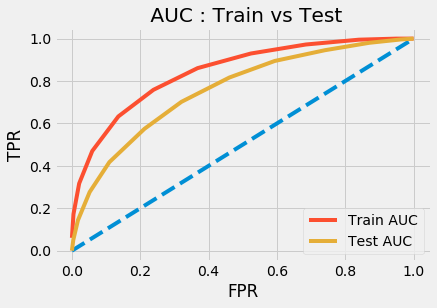

In [69]:
fpr_train , tpr_train ,thresholds = roc_curve(y_train_less,train_proba[:,1],pos_label=1) 
fpr_test , tpr_test ,thresholds = roc_curve(y_test_less,test_proba[:,1],pos_label=1) 
plt.plot([0,1],[0,1],'--')
plt.plot(fpr_train,tpr_train,label='Train AUC')
plt.plot(fpr_test,tpr_test,label='Test AUC')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(" AUC : Train vs Test")
plt.show()

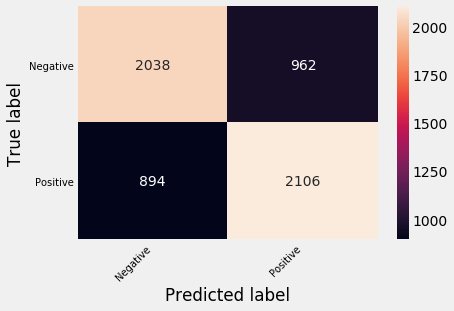

In [70]:

C = confusion_matrix(y_test_less , test_pred)
fontsize = 10
df_cm = pd.DataFrame(
        C, index=classes, columns=classes, 
    )
fig = plt.figure()
try:
  heatmap_ = heatmap(df_cm, annot=True, fmt="d")
except ValueError:
  raise ValueError("Confusion matrix values must be integers.")
heatmap_.yaxis.set_ticklabels(heatmap_.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap_.xaxis.set_ticklabels(heatmap_.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [71]:
del text_train_tfidf_r,text_cv_tfidf_r,text_test_tfidf_r

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [23]:




parameter = [i for i in range(3,15,2)]
train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1= training(x_train_avg_w2v_r , y_train_avg_w2v_r,
                                                           x_cv_avg_w2v_r , y_cv_avg_w2v_r,parameter,'kd_tree')



Training for Parameter: 3
Train AUC for 3 parameter: 0.94743241
CV AUC for 3 parameter: 0.82938136
Train Accuracy for 3 parameter: 0.8767
CV Accuracy for 3 parameter: 0.7744
Train F1 Score for 3 parameter: 0.874898538961039
CV F1 Score for 3 parameter: 0.7687576875768759
--------------------------------------------------------------------------------
Training for Parameter: 5
Train AUC for 5 parameter: 0.9343627250000001
CV AUC for 5 parameter: 0.8552098400000001
Train Accuracy for 5 parameter: 0.8566
CV Accuracy for 5 parameter: 0.788
Train F1 Score for 5 parameter: 0.853479104935118
CV F1 Score for 5 parameter: 0.7828758705448587
--------------------------------------------------------------------------------
Training for Parameter: 7
Train AUC for 7 parameter: 0.927037505
CV AUC for 7 parameter: 0.8685584799999999
Train Accuracy for 7 parameter: 0.8492
CV Accuracy for 7 parameter: 0.7944
Train F1 Score for 7 parameter: 0.8457131164313485
CV F1 Score for 7 parameter: 0.78917145200984

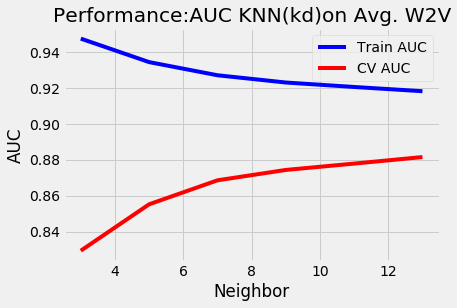

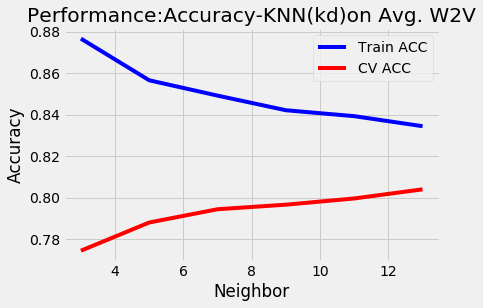

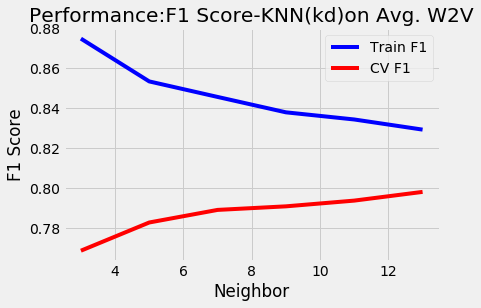

In [24]:
plt.style.use('fivethirtyeight')
plotting_plot(train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1,"(kd)",' Avg. W2V')

### Observation:
- From the above graph and output of training function, it can be easily observed that the difference between train score and cv score is decreasing further and cv score is also increasing, so training our model on further values of parameter(n_neighbors>13)


In [33]:

# using the modified version of training function because of extension of checking of hyperparameter.

parameter = [i for i in range(15,20,2)]
train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1= modified_training(x_train_avg_w2v_r , y_train_avg_w2v_r,
                                                           x_cv_avg_w2v_r , y_cv_avg_w2v_r,parameter,'kd_tree',
                                                                   train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1)




Training for Parameter: 15
Train AUC for 15 parameter: 0.916605235
CV AUC for 15 parameter: 0.8843764000000001
Train Accuracy for 15 parameter: 0.83385
CV Accuracy for 15 parameter: 0.804
Train F1 Score for 15 parameter: 0.8282953547253654
CV F1 Score for 15 parameter: 0.7971854304635762
--------------------------------------------------------------------------------
Training for Parameter: 17
Train AUC for 17 parameter: 0.91491785
CV AUC for 17 parameter: 0.8849610400000001
Train Accuracy for 17 parameter: 0.83275
CV Accuracy for 17 parameter: 0.8094
Train F1 Score for 17 parameter: 0.8270871026104938
CV F1 Score for 17 parameter: 0.8028139871715291
--------------------------------------------------------------------------------
Training for Parameter: 19
Train AUC for 19 parameter: 0.914165925
CV AUC for 19 parameter: 0.88654944
Train Accuracy for 19 parameter: 0.8318
CV Accuracy for 19 parameter: 0.809
Train F1 Score for 19 parameter: 0.8257355988396188
CV F1 Score for 19 parameter:

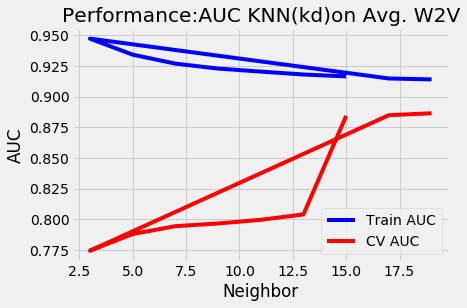

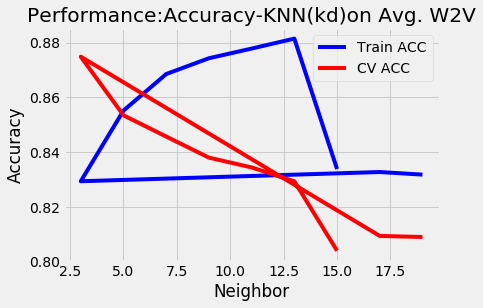

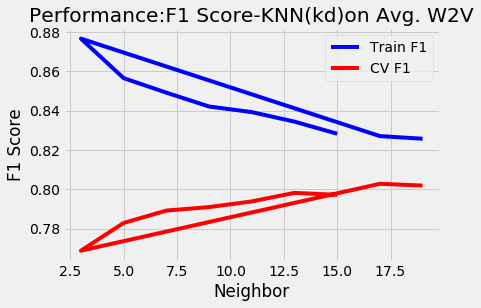

In [36]:
plt.style.use('fivethirtyeight')
plotting_plot(train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1,"(kd)",' Avg. W2V')

### Observation:
- From the above graph and output of training function, it can be easily observed that parameter(n_neighbors=19) is optimal as for this parameter the difference between train score and cv score is minimum out of every parameter and the cv score is also high for this paramter which implies that our model is neither overfit nor underfit for this parameter. 

In [39]:
'''
CHOOSE YOUR BEST MODEL HERE
'''
print(train_auc)
print(cv_auc)
algo = 'kd_tree'
best_clf = KNeighborsClassifier(n_neighbors=19,algorithm=algo)


best_clf.fit(x_train_avg_w2v_r , y_train_avg_w2v_r)

train_pred = best_clf.predict(x_train_avg_w2v_r)
train_proba = best_clf.predict_proba(x_train_avg_w2v_r)
test_pred = best_clf.predict(x_test_avg_w2v_r)
test_proba = best_clf.predict_proba(x_test_avg_w2v_r)


print(" AUC: {}".format(roc_auc_score(y_test_avg_w2v_r,test_pred)))
print(" Accuracy: {}".format(accuracy_score(y_test_avg_w2v_r,test_pred)))
print(" F1 Score: {}".format(f1_score(y_test_avg_w2v_r,test_pred)))




{19: 0.914165925, 17: 0.91491785, 3: 0.94743241, 5: 0.9343627250000001, 7: 0.927037505, 9: 0.92300169, 11: 0.920520825, 13: 0.91816136, 15: 0.916605235}
{19: 0.88654944, 17: 0.8849610400000001, 3: 0.7744, 5: 0.788, 7: 0.7944, 9: 0.7966, 11: 0.7996, 13: 0.804, 15: 0.8843764000000001}
 AUC: 0.8190525949146638
 Accuracy: 0.8190525949146639
 F1 Score: 0.8113995280450172


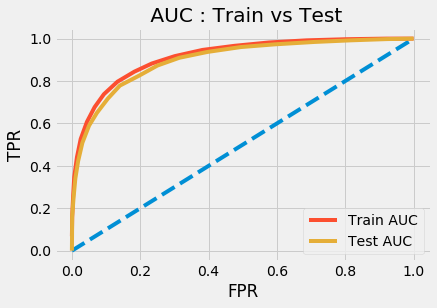

In [40]:
fpr_train , tpr_train ,thresholds = roc_curve(y_train_avg_w2v_r,train_proba[:,1],pos_label=1) 
fpr_test , tpr_test ,thresholds = roc_curve(y_test_avg_w2v_r,test_proba[:,1],pos_label=1) 
plt.plot([0,1],[0,1],'--')
plt.plot(fpr_train,tpr_train,label='Train AUC')
plt.plot(fpr_test,tpr_test,label='Test AUC')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(" AUC : Train vs Test")
plt.show()

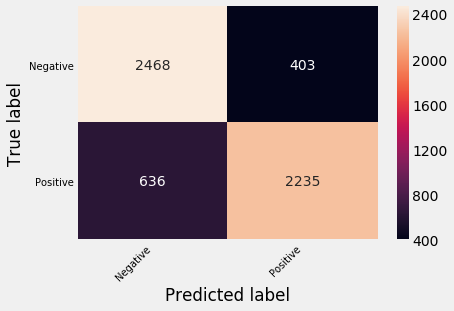

In [41]:
from seaborn import heatmap
classes = ['Negative','Positive']
C = confusion_matrix(y_test_avg_w2v_r , test_pred)
fontsize = 10
df_cm = pd.DataFrame(
        C, index=classes, columns=classes, 
    )
fig = plt.figure()
try:
  heatmap_ = heatmap(df_cm, annot=True, fmt="d")
except ValueError:
  raise ValueError("Confusion matrix values must be integers.")
heatmap_.yaxis.set_ticklabels(heatmap_.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap_.xaxis.set_ticklabels(heatmap_.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [43]:




parameter = [i for i in range(3,17,2)]
train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1= training(x_train_tfidf_w2v_r , y_train_tfidf_w2v_r,
                                                           x_cv_tfidf_w2v_r , y_cv_tfidf_w2v_r,parameter,'kd_tree')





Training for Parameter: 3
Train AUC for 3 parameter: 0.93936503
CV AUC for 3 parameter: 0.80120528
Train Accuracy for 3 parameter: 0.86925
CV Accuracy for 3 parameter: 0.743
Train F1 Score for 3 parameter: 0.8680425896957158
CV F1 Score for 3 parameter: 0.7439729029687189
--------------------------------------------------------------------------------
Training for Parameter: 5
Train AUC for 5 parameter: 0.920882785
CV AUC for 5 parameter: 0.82446584
Train Accuracy for 5 parameter: 0.84305
CV Accuracy for 5 parameter: 0.7532
Train F1 Score for 5 parameter: 0.8411839109537061
CV F1 Score for 5 parameter: 0.7530024019215372
--------------------------------------------------------------------------------
Training for Parameter: 7
Train AUC for 7 parameter: 0.9109411599999999
CV AUC for 7 parameter: 0.83818496
Train Accuracy for 7 parameter: 0.82875
CV Accuracy for 7 parameter: 0.7606
Train F1 Score for 7 parameter: 0.8265910586805731
CV F1 Score for 7 parameter: 0.7589123867069487
--------

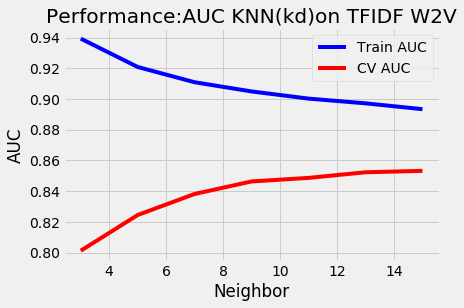

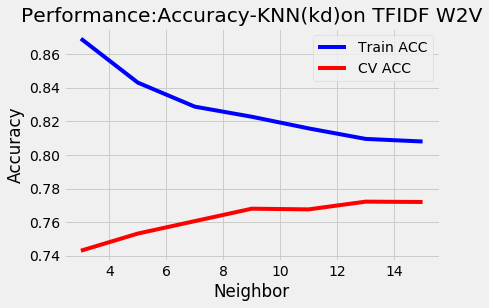

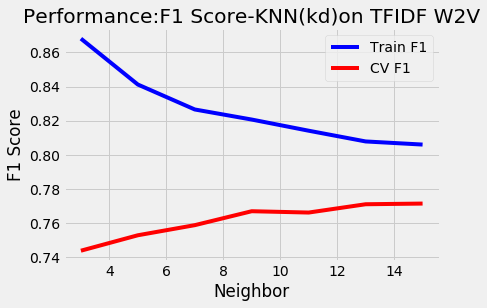

In [44]:
plt.style.use('fivethirtyeight')
plotting_plot(train_auc,cv_auc,train_acc,cv_acc,train_f1,cv_f1,"(kd)",' TFIDF W2V')

### Observation:
- From the above graph and output of training function, it can be easily observed that parameter(n_neighbors=15) is optimal as for this parameter the difference between train score and cv score is minimum out of every parameter and the cv score is also high for this paramter which implies that our model is neither overfit nor underfit for this parameter. 

In [46]:
'''
CHOOSE YOUR BEST MODEL HERE
'''
print(train_auc)
print(cv_auc)
algo = 'kd_tree'
best_clf = KNeighborsClassifier(n_neighbors=15,algorithm=algo)


best_clf.fit(x_train_tfidf_w2v_r , y_train_tfidf_w2v_r)

train_pred = best_clf.predict(x_train_tfidf_w2v_r )
train_proba = best_clf.predict_proba(x_train_tfidf_w2v_r )
test_pred = best_clf.predict(x_test_tfidf_w2v_r )
test_proba = best_clf.predict_proba(x_test_tfidf_w2v_r )


print(" AUC: {}".format(roc_auc_score(y_test_tfidf_w2v_r,test_pred)))
print(" Accuracy: {}".format(accuracy_score(y_test_tfidf_w2v_r,test_pred)))
print(" F1 Score: {}".format(f1_score(y_test_tfidf_w2v_r,test_pred)))






{3: 0.93936503, 5: 0.920882785, 7: 0.9109411599999999, 9: 0.9049512900000001, 11: 0.900282475, 13: 0.897211875, 15: 0.8933929899999999}
{3: 0.80120528, 5: 0.82446584, 7: 0.83818496, 9: 0.8463267199999999, 11: 0.8486336800000001, 13: 0.8522964, 15: 0.85321264}
 AUC: 0.7793451758969
 Accuracy: 0.7793451758969
 F1 Score: 0.7772111834007386


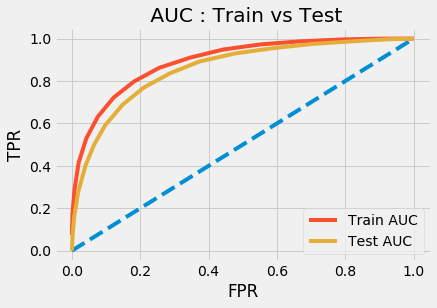

In [47]:
fpr_train , tpr_train ,thresholds = roc_curve(y_train_tfidf_w2v_r,train_proba[:,1],pos_label=1) 
fpr_test , tpr_test ,thresholds = roc_curve(y_test_tfidf_w2v_r,test_proba[:,1],pos_label=1) 
plt.plot([0,1],[0,1],'--')
plt.plot(fpr_train,tpr_train,label='Train AUC')
plt.plot(fpr_test,tpr_test,label='Test AUC')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(" AUC : Train vs Test")
plt.show()

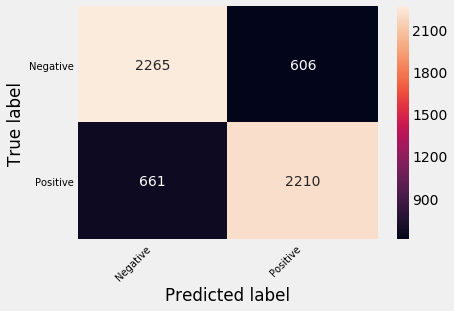

In [53]:

C = confusion_matrix(y_test_tfidf_w2v_r , test_pred)
fontsize = 10
df_cm = pd.DataFrame(
        C, index=classes, columns=classes, 
    )
fig = plt.figure()
try:
  heatmap_ = heatmap(df_cm, annot=True, fmt="d")
except ValueError:
  raise ValueError("Confusion matrix values must be integers.")
heatmap_.yaxis.set_ticklabels(heatmap_.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap_.xaxis.set_ticklabels(heatmap_.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# [6] Conclusions

In [1]:
from prettytable import PrettyTable

In [18]:
x = PrettyTable()
x.field_names = ['Model','Vectorizer','Hyperparameter','AUC']

x.add_row(['KNN Brute','BOW','9','0.68'])
x.add_row(['----------','----------','----------','-----'])
x.add_row(['KNN Brute','TF IDF','5','0.55'])
x.add_row(['----------','----------','----------','-----'])
x.add_row(['KNN Brute','Avg. W2V','13','0.80'])
x.add_row(['----------','----------','----------','-----'])
x.add_row(['KNN Brute','Tfidf W2V','13','0.78'])
x.add_row(['----------','----------','----------','-----'])
x.add_row(['----------','----------','----------','-----'])
x.add_row(['----------','----------','----------','-----'])

x.add_row(['KNN KdTree','BOW','11','0.69'])
x.add_row(['----------','----------','----------','-----'])
x.add_row(['KNN KdTree','TF IDF','11','0.69'])
x.add_row(['----------','----------','----------','-----'])
x.add_row(['KNN KdTree','Avg. W2V','19','0.81'])
x.add_row(['----------','----------','----------','-----'])
x.add_row(['KNN KdTree','Tfidf W2V','15','0.77'])
x.add_row(['----------','----------','----------','-----'])
print(x)

+------------+------------+----------------+-------+
|   Model    | Vectorizer | Hyperparameter |  AUC  |
+------------+------------+----------------+-------+
| KNN Brute  |    BOW     |       9        |  0.68 |
| ---------- | ---------- |   ----------   | ----- |
| KNN Brute  |   TF IDF   |       5        |  0.55 |
| ---------- | ---------- |   ----------   | ----- |
| KNN Brute  |  Avg. W2V  |       13       |  0.80 |
| ---------- | ---------- |   ----------   | ----- |
| KNN Brute  | Tfidf W2V  |       13       |  0.78 |
| ---------- | ---------- |   ----------   | ----- |
| ---------- | ---------- |   ----------   | ----- |
| ---------- | ---------- |   ----------   | ----- |
| KNN KdTree |    BOW     |       11       |  0.69 |
| ---------- | ---------- |   ----------   | ----- |
| KNN KdTree |   TF IDF   |       11       |  0.69 |
| ---------- | ---------- |   ----------   | ----- |
| KNN KdTree |  Avg. W2V  |       19       |  0.81 |
| ---------- | ---------- |   ----------   | -

- The more good KNN looks in theory, the more bad it is in practical.
- KNN takes so much time and it really computationally expensive algorithm.
- KD Tree is performs better than Brute force but at the cost of computation
- As expected, Word2Vec outperforms both Bag of words and TF-IDF Vectorization
- Average Word2Vec outperforms TF-IDF Word2Vec
- The best model for this particular problem is KNN (KD TREE) with Avg. Word2Vec Vectorization with the AUC=0.81